# Causal discovery with `TIGRAMITE`

TIGRAMITE is a time series analysis python module. It allows to reconstruct graphical models (conditional independence graphs) from discrete or continuously-valued time series based on the PCMCI framework and create high-quality plots of the results.
This tutorial explains the main features in walk-through examples. It covers:

1. Basic usage
2. Plotting
3. Nonlinear conditional independence tests
4. Symbolic time series

PCMCI is described here:
J. Runge, P. Nowack, M. Kretschmer, S. Flaxman, D. Sejdinovic, 
Detecting and quantifying causal associations in large nonlinear time series datasets. Sci. Adv. 5, eaau4996 (2019) 
https://advances.sciencemag.org/content/5/11/eaau4996

For further versions of PCMCI (e.g., PCMCI+, LPCMCI, etc.), see the corresponding tutorials.

See the following paper for theoretical background:
Runge, Jakob. 2018. “Causal Network Reconstruction from Time Series: From Theoretical Assumptions to Practical Estimation.” Chaos: An Interdisciplinary Journal of Nonlinear Science 28 (7): 075310.

Last, the following Nature Communications Perspective paper provides an overview of causal inference methods in general, identifies promising applications, and discusses methodological challenges (exemplified in Earth system sciences): 
https://www.nature.com/articles/s41467-019-10105-3

## 1. Basic usage

In [4]:
# Imports
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib
import sklearn
from matplotlib import pyplot as plt
%matplotlib inline     

import tigramite
from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import ParCorr

/g/data/os22/chad_tmp/NEE_modelling/env/nee/lib/python3.8/site-packages/tigramite/plotting.py:26: UserWarning: [Errno 2] No such file or directory: '/g/data/os22/chad_tmp/NEE_modelling/env/nee/lib/python3.8/site-packages/tigramite/../versions.py'
  warnings.warn(str(e))
/g/data/os22/chad_tmp/NEE_modelling/env/nee/lib/python3.8/site-packages/tigramite/independence_tests/gpdc.py:27: UserWarning: [Errno 2] No such file or directory: '/g/data/os22/chad_tmp/NEE_modelling/env/nee/lib/python3.8/site-packages/tigramite/independence_tests/../../versions.py'
  warnings.warn(str(e))
/g/data/os22/chad_tmp/NEE_modelling/env/nee/lib/python3.8/site-packages/tigramite/independence_tests/gpdc_torch.py:33: UserWarning: No module named 'torch'
  warnings.warn(str(e))


## Analysis Paramaters

AliceSpringsMulga/2022_v1/L6/default/AliceSpringsMulga_L6_20100903_20211231_Monthly.nc

Whroo/2022_v1/L6/default/Whroo_L6_20111201_20220218_Monthly.nc

Whroo/2022_v1/L6/default/Whroo_L6_20111201_20220218_Daily.nc

DryRiver/2022_v1/L6/default/DryRiver_L6_20091025_20220218_Monthly.nc


AliceSpringsMulga/2022_v1/L6/default/AliceSpringsMulga_L6_20100903_20211231_Daily.nc

In [5]:
site = 'AliceSpringsMulga/2022_v1/L6/default/AliceSpringsMulga_L6_20100903_20211231_Daily.nc'
var = ['GPP_SOLO', 'Ta', 'VPD', 'Precip', 'Fsd']
var_names = ['GPP','Ta','VPD', 'precip','solar']
max_lag = 180
# months = [6,7,8]

## Open and process data

In [6]:
def VPD(rh, ta):
    sat_vp = (6.11 * np.exp((2500000/461) * (1/273 - 1/(273 + ta))))
    vpd = (((100 - rh)/100) * sat_vp)
    return vpd

In [7]:
ds = xr.open_dataset('https://dap.tern.org.au/thredds/dodsC/ecosystem_process/ozflux/'+site)
# ds = ds.sel(time=ds.time.dt.month.isin(months))

ds['GPP_SOLO'] = xr.where(ds.GPP_SOLO < 0, 0, ds.GPP_SOLO)  #Set negative GPP, ER, and ET measurements as zero
ds['ER_SOLO'] = xr.where(ds.ER_SOLO < 0, 0, ds.ER_SOLO) 
ds['ET'] = xr.where(ds.ET < 0, 0, ds.ET)  

df = ds.to_dataframe().reset_index(
        level=[1, 2]).drop(['latitude', 'longitude'], axis=1)

# calculate VPD on ec data
df['VPD'] = VPD(df.RH, df.Ta)
df = df[var].dropna()

data = df.values
T, N = data.shape

# Initialize dataframe object, specify time axis and variable names
dataframe = pp.DataFrame(data, 
                         datatime = {0:np.arange(len(data))}, 
                         var_names=var_names)


First, we plot the time series. This can be done with the function ``tp.plot_timeseries``

(<Figure size 432x288 with 5 Axes>,
 array([<AxesSubplot:ylabel='GPP'>, <AxesSubplot:ylabel='Ta'>,
        <AxesSubplot:ylabel='VPD'>, <AxesSubplot:ylabel='precip'>,
        <AxesSubplot:xlabel='time', ylabel='solar'>], dtype=object))

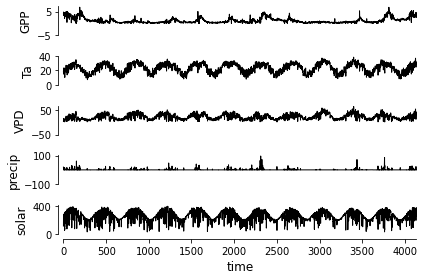

In [8]:
tp.plot_timeseries(dataframe)

It's stationary and doesn't contain missing values (covered in other tutorial). Next, we choose a conditional independence test, here we start with ``ParCorr`` implementing linear partial correlation. With ``significance='analytic'`` the null distribution is assumed to be Student's $t$. Then we initialize the ``PCMCI`` method with  ``dataframe``, and ``cond_ind_test``:

In [ ]:
parcorr = ParCorr(significance='analytic')
pcmci = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=parcorr,
    verbosity=1)

Before running the causal algorithm, it's a good idea to plot the lagged unconditional dependencies, e.g., the lagged correlations. This can help to identify which maximal time lag ``tau_max`` to choose in the causal algorithm.

In [ ]:
correlations = pcmci.get_lagged_dependencies(tau_max=max_lag, val_only=True)['val_matrix']
lag_func_matrix = tp.plot_lagfuncs(val_matrix=correlations, 
                                   setup_args={'var_names':var_names, 'figsize':(15, 10),
                                    'x_base':5, 'y_base':.5})

Let's do another check and use the new ``plot_scatterplots`` function to see whether the dependencies are really linear and ``ParCorr`` is the right conditional independence test. With the argument ``scatter_lags`` set to a ``(N, N)`` integer numpy array you can choose which lag to use for every pair of variables. Here we choose the lag at which the correlations above have their maximal absolute value. Of course, you might want to use a nonlinear conditional independence test to assess the lags with maximum dependency. I.e., run ``pcmci.get_lagged_dependencies`` with ``PCMCI`` initialized with a nonlinear measure (e.g., CMIknn or GPDC as introduced below).

In [ ]:
scatter_lags = np.argmax(np.abs(correlations), axis=2)
tp.plot_scatterplots(dataframe=dataframe, setup_args={'figsize':(15, 10)}, add_scatterplot_args={'scatter_lags':scatter_lags});

Since the dependencies in the lag function plot decay beyond a maximum lag of around 8, we choose ``tau_max=8`` for PCMCI. The other main parameter is ``pc_alpha`` which sets the significance level in the condition-selection step. Here we let PCMCI choose the optimal value by setting it to ``pc_alpha=None``. Then PCMCI will optimize this parameter in the ParCorr case by the Akaike Information criterion among a reasonable default list of values (e.g., ``pc_alpha = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]``). The parameter ``alpha_level=0.01`` indicates that we threshold the resulting p-value matrix at this significance level to obtain the graph. 

In [ ]:
tau_max = 2

In [ ]:
# Only estimate parents of variables 0, 1, 2, 3
selected_links = {}

for j in range(N):
    if j in list(range(N-1)):
        selected_links[j] = [(var, -lag) for var in range(N)
                         for lag in range(0, tau_max + 1)]
    else:
        selected_links[j] = []

In [ ]:
pcmci.verbosity = 1
results = pcmci.run_pcmci(tau_max=tau_max, pc_alpha=None, alpha_level=0.01, selected_links=selected_links)

As you can see from the output, PCMCI selected different ``pc_alpha`` for each variable. The result of ``run_pcmci`` is a dictionary containing the matrix of p-values, the matrix of test statistic values (here MCI partial correlations) and optionally its confidence bounds (can be specified upon initializing ``ParCorr``), and the ``graph`` matrix. ``p_matrix`` and ``val_matrix`` are of shape ``(N, N, tau_max+1)`` with entry ``(i, j, \tau)`` denoting the test for the link $X^i_{t-\tau} \to X^j_t$. The MCI values for $\tau=0$ do not exclude other contemporaneous effects, only past variables are conditioned upon. The ``graph`` array of the same shape is obtained from thresholding the ``p_matrix`` at the specified ``alpha_level``. It is a string array and denotes significant lagged causal links by ``-->`` and contemporaneou links (where the orientation cannot be determined with PCMCI) by ``o-o``. With the PCMCIplus method also contemporaneous links can be oriented.

__Note:__ The test statistic values (e.g., partial correlation) may give a qualitative intuition of the `strength` of a dependency, but for a proper causal effect analysis please refer to the ``CausalEffects`` class and tutorial.

In [ ]:
# print("p-values")
# print (results['p_matrix'].round(3))
# print("MCI partial correlations")
# print (results['val_matrix'].round(2))

If we want to control for the $N^2 \tau_\max$ tests conducted here, we can further correct the p-values, e.g., by False Discovery Rate (FDR) control yielding the ``q_matrix``. The graph can then be updated with that adjusted ``p_matrix`` and a different ``alpha_level`` using ``get_graph_from_pmatrix()``.

In [ ]:
# q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'],
#                                        tau_max=tau_max,
#                                        fdr_method='fdr_bh',
#                                        selected_links=selected_links)

# pcmci.print_significant_links(
#         p_matrix = q_matrix,
#         val_matrix = results['val_matrix'],
#         alpha_level = 0.01)

# graph = pcmci.get_graph_from_pmatrix(p_matrix=q_matrix, alpha_level=0.01, 
#             tau_min=0, tau_max=tau_max, selected_links=selected_links)
# results['graph'] = graph

## 2. Plotting

Tigramite offers several plotting options: The lag function matrix (as shown above), the time series graph, and the process graph which aggregates the information in the time series graph. Both take as arguments the ``graph`` array and optionally the ``val_matrix`` and further link attributes.

In the process graph, the node color denotes the auto-MCI value and the link colors the cross-MCI value. If links occur at multiple lags between two variables, the link color denotes the strongest one and the label lists all significant lags in order of their strength.

In [ ]:
tp.plot_graph(
    figsize=(8,5),
    val_matrix=results['val_matrix'],
    graph=results['graph'],
    var_names=var_names,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    );

In [ ]:
# Plot time series graph    
tp.plot_time_series_graph(
    figsize=(10, 8),
    node_size=0.05,
    val_matrix=results['val_matrix'],
    graph=results['graph'],
    var_names=var_names,
    link_colorbar_label='MCI',
    ); plt.show()

While the process graph is nicer to look at, the time series graph better represents the spatio-temporal dependency structure from which causal pathways can be read off. You can adjust the size and aspect ratio of nodes with `node_size` and `node_aspect` parameters, and also modify many other properties, see the parameters of `plot_graph` and `plot_time_series_graph`.

### CMIknn

The most general conditional independence test implemented in Tigramite is CMIknn based on conditional mutual information estimated with a k-nearest neighbor estimator. This test is described in the paper 

Runge, Jakob. 2018. “Conditional Independence Testing Based on a Nearest-Neighbor Estimator of Conditional Mutual Information.” In Proceedings of the 21st International Conference on Artificial Intelligence and Statistics. 

CMIknn involves no assumptions about the dependencies. The parameter ``knn`` determines the size of hypercubes, ie., the (data-adaptive) local length-scale. Now we cannot even pre-compute the null distribution because CMIknn is not residual-based like GPDC and the null distribution depends on many more factors. We, therefore, use ``significance='shuffle_test'`` to generate it in each individual test. The shuffle test for testing $I(X;Y|Z)=0$ shuffles $X$ values *locally*: Each sample point $i$’s $x$-value is mapped randomly
to one of its nearest neigbors (``shuffle_neighbors`` parameter) in subspace $Z$. Another free parameter is ``transform`` which specifies whether data is transformed before CMI estimation. The new default is ``transform=ranks`` which works better than the old ``transform=standardize``.
The following cell may take some minutes.

In [ ]:
cmi_knn = CMIknn(significance='shuffle_test', knn=0.1, shuffle_neighbors=5, transform='ranks')
pcmci_cmi_knn = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=cmi_knn,
    verbosity=2)
results = pcmci_cmi_knn.run_pcmci(tau_max=3, pc_alpha=0.05, alpha_level = 0.01)

In [ ]:
## Significant links at alpha = 0.01:

#     Variable $X^0$ has 1 link(s):
#         ($X^1$ -1): pval = 0.00000 | val = 0.284

#     Variable $X^1$ has 0 link(s):

#     Variable $X^2$ has 1 link(s):
#         ($X^1$ -2): pval = 0.00000 | val = 0.242

In [ ]:
tp.plot_graph(
    val_matrix=results['val_matrix'],
    graph=results['graph'],
    var_names=var_names,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    vmin_edges=0.,
    vmax_edges = 0.3,
    edge_ticks=0.05,
    cmap_edges='OrRd',
    vmin_nodes=0,
    vmax_nodes=.5,
    node_ticks=.1,
    cmap_nodes='OrRd',
    ); plt.show()

Here CMIknn correctly detects the true links and also unveils the spurious link. While CMIknn may now seem as the best independence test choice, we have to note that the generality comes at the cost of much lower power for the case that the dependencies actually follow some parametric form. Then ParCorr or GPDC are much more powerful measures. Of course, ParCorr also detects linear links better than GPDC. 